In [ ]:
!pip3 install catboost
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit
# import visuals as vs
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15, 6.18*1.5]

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
import catboost
from sklearn.inspection import permutation_importance
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
import sys
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.preprocessing import OrdinalEncoder
from google.colab import files
from joblib import dump, load

In [ ]:
!gdown --id  1K7N4QCyCzPYoEBd3Mwvy6P5VGokT5su4  --output "train.csv" 
!gdown --id  1DpiEPo2WuNfCrDl7xfGhCWPsCKPNGRXm  --output "test.csv" 

Downloading...
From: https://drive.google.com/uc?id=1K7N4QCyCzPYoEBd3Mwvy6P5VGokT5su4
To: /content/train.csv
100% 116M/116M [00:01<00:00, 65.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DpiEPo2WuNfCrDl7xfGhCWPsCKPNGRXm
To: /content/test.csv
100% 116M/116M [00:01<00:00, 91.2MB/s]


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head(5)

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,...,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,16.434108,6.085711,2.866830,11.636387,1.355013,8.571429,3.670350,0.106720,0.148883,18.869283,7.730923,XDX,-1.716131e-08,C,0.139412,1.720818,3.393503,0.590122,8.880867,C,A,1.083033,1.010829,7.270147,8.375452,11.326592,0.454546,0,...,0.442252,5.814018,3.517720,0.462019,7.436824,5.454545,8.877414,1.191337,19.470199,8.389237,2.757375,4.374296,1.574039,0.007294,12.579184,E,2.382692,3.930922,B,0.433213,O,NaN,15.634907,2.857144,1.951220,6.592012,5.909091,-6.297423e-07,1.059603,0.803572,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,NaN,1.312910,NaN,6.507647,NaN,11.636386,NaN,NaN,NaN,NaN,NaN,NaN,6.763110,GUV,NaN,C,3.056144,NaN,NaN,NaN,NaN,C,A,NaN,NaN,3.615077,NaN,14.579479,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.303967,NaN,NaN,NaN,NaN,NaN,NaN,1.505335,NaN,B,1.825361,4.247858,A,NaN,U,G,10.308044,NaN,NaN,10.595357,NaN,NaN,NaN,NaN,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,14.756098,6.384670,2.505589,9.603542,1.984127,5.882353,3.170847,0.244541,0.144258,17.952332,5.245035,FQ,-2.785053e-07,E,0.113997,2.244897,5.306122,0.836005,7.499999,NaN,A,1.454082,1.734693,4.043864,7.959184,12.730517,0.259740,0,...,0.271480,5.156559,4.214944,0.309657,5.663265,5.974026,11.588858,0.841837,15.491329,5.879353,3.292788,5.924457,1.668401,0.008275,11.670572,C,1.375753,1.184211,B,3.367348,S,NaN,11.205561,12.941177,3.129253,3.478911,6.233767,-2.792745e-07,2.138728,2.238806,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,16.347483,9.646653,3.903302,14.094723,1.945044,5.517242,3.610789,1.224114,0.231630,18.376407,7.517125,ACUE,-4.805344e-07,D,0.148843,1.308269,2.303640,8.926662,8.874521,C,B,1.587644,1.666667,8.703550,8.898468,11.302795,0.433735,0,...,0.763925,5.498902,3.423944,0.832518,7.375480,6.746988,6.942002,1.334611,18.256352,8.507281,2.503055,4.872157,2.573664,0.113967,12.554274,B,2.230754,1.990131,B,2.643678,J,NaN,13.777666,10.574713,1.511063,4.949609,7.180722,5.655086e-01,1.166281,1.956521,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.050328,NaN,6.320087,NaN,10.991098,NaN,NaN,NaN,NaN,NaN,NaN,6.414567,HIT,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,6.083151,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,A,NaN,T,G,14.097099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [ ]:
test.shape

(114393, 132)

In [ ]:
# train[cat_col.columns] = train[cat_col.columns].astype(str)

In [ ]:
X_train = train.drop(columns=['target'])
y_train = train['target']

I tried many different methods to get the better log-loss. The first method I tried is only use Cat-boost Classification to see what log-loss I gonna have.

# Method 1 Catboost and do nothing: 0.43767 -- 60%

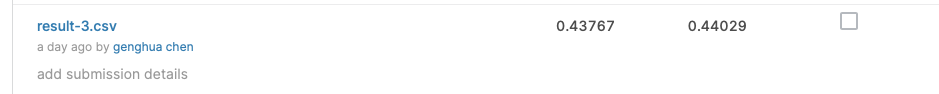

The first step is to distinguish which columns are categorical variables. The main purpose is to separate categorical and numerical columns, so that I can get a better prediction.

In [ ]:
cat_col = X_train.select_dtypes(include=[object])
cat_features = [X_train.columns.get_loc(col) for col in cat_col.columns]
cat_features

[3,
 22,
 24,
 30,
 31,
 47,
 52,
 56,
 66,
 71,
 74,
 75,
 79,
 91,
 107,
 110,
 112,
 113,
 125]

This cell is to make the date type of these categorical columns to string because the Catboost cannot handle ‘Object’ data type, it will return error in this case. Also, I only keep 2 digits decimal points for all the numerical feature, I got the idea from the third of the leaderboard. And it does improve my model. I think the reason behaind is that if I have too many decimal points, all of them are going to be unique, but if I only keep two decimal points, it's going to have more pattern for each data point.

In [ ]:
test[cat_col.columns] = test[cat_col.columns].astype(str)
method_1 = X_train.round(2)
method_1[cat_col.columns] = method_1[cat_col.columns].astype(str)

In [ ]:
# encoder = ce.CatBoostEncoder(cols=cat_col.columns)
# X_train_enc = encoder.fit_transform(X_train, y_train)
# X_test_enc = encoder.fit_transform(X_test, y_test)

Now is exciting moment, I use Catboost to fit our model, The hyper-parameters I set is random_seed:72, the reason is 72 might return a good score since I tested and make sure the result is the same every time I run. ‘cat’_features is to tell catboost which are categorical columns. ‘Iterations’ is trying to get the better prediction, 2000 looks good to me.

In [ ]:
params = {
          # "eval_metric": "TotalF1:average=Macro",
          'verbose': 200, 
          'random_seed': 72,
          'cat_features': cat_features,
          'iterations': 2000,
          # 'nan_mode': 'Min',
          }
cat = CatBoostClassifier(**params)


cat.fit(method_1, y_train,
        use_best_model=True,
         )
print(cat.get_best_score())

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.041277
0:	learn: 0.6745837	total: 551ms	remaining: 18m 21s
200:	learn: 0.4555663	total: 1m 50s	remaining: 16m 31s
400:	learn: 0.4460552	total: 3m 36s	remaining: 14m 22s
600:	learn: 0.4395288	total: 5m 19s	remaining: 12m 24s
800:	learn: 0.4342941	total: 7m 6s	remaining: 10m 38s
1000:	learn: 0.4294277	total: 8m 51s	remaining: 8m 50s
1200:	learn: 0.4248184	total: 10m 37s	remaining: 7m 3s
1400:	learn: 0.4204068	total: 12m 23s	remaining: 5m 17s
1600:	learn: 0.4161486	total: 14m 9s	remaining: 3m 31s
1800:	learn: 0.4118987	total: 15m 57s	remaining: 1m 45s
1999:	learn: 0.4078554	total: 17m 44s	remaining: 0us
{'learn': {'Logloss': 0.4078553882839576}}


Since I want the prediction format as log-loss, so I use predict_proba to make prediction, and I will have two list of probabilities. And I save as csv and back to Kaggle and see what is the log-loss. Surprisedly, I got 0.43767.

In [ ]:
preds_proba = cat.predict_proba(test)
# pred = cat.predict(X_test_enc)
df = pd.DataFrame(preds_proba, columns = ['2', 'PredictedProb'])

In [ ]:
df['ID'] = test['ID']
df = df.drop(columns=['2'])
df = df[['ID', 'PredictedProb']]

In [ ]:
df.to_csv('result.csv', index=False)

--------------------------------------------------------------------------------------------------------------------------------------------

# Method 2: Categorical Features interation with catboost Classifier:0.43259 -- 80%

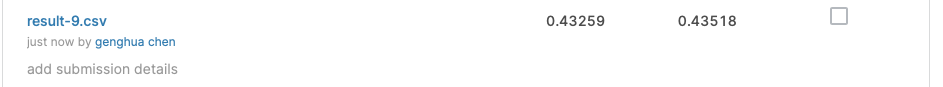

The second method I used is based on the method 1, because I am very satisfied with the log-loss of the first method.

First Step is excatly same as method 1, I select all the categorical features. And make as string data types. Set the decimal points = 2 as well.

In [ ]:
cat_col = X_train.select_dtypes(include=[object])
cat_features = [X_train.columns.get_loc(col) for col in cat_col.columns]

In [ ]:
X_train[cat_col.columns] = X_train[cat_col.columns].astype(str)

In [ ]:
method_15 = X_train.round(2)

This time I want to do the feature selection by using Catboost select_features. After read all the documentations, I decided to use 'RecursiveByLossFunctionChange' as my algorithm and shap is Exact(default and this don't have that much changes.), I also Plot the loss plot.

I decieded to eliminated 9 columns, which are ['v72','v31' ,'v3','v62','v129','v74','v81','v54','v76'] based on the loss plot, since after eliminate 'v76' column, then the loss value start to increase, I realized that is the one I should stop to eliminated more cloumns.



In [ ]:
params = {
          # "eval_metric": "TotalF1:average=Macro",
          'verbose': 200, 
          'random_seed': 72,
          'cat_features': cat_features,
          # 'nan_mode': 'Min',
          }
cat = CatBoostClassifier(**params)

cat.select_features(
                method_15,
                y_train,
                eval_set=None,
                features_for_select=method_15.columns.to_list(),
                num_features_to_select=30,
                algorithm='RecursiveByLossFunctionChange',
                shap_calc_type = 'Exact',
                train_final_model=False,
                plot = True,
                verbose=200,
                log_cout=sys.stdout,
                log_cerr=sys.stderr)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.077939
Step #1 out of 1
0:	learn: 0.6586122	total: 443ms	remaining: 7m 22s
200:	learn: 0.4475462	total: 1m 17s	remaining: 5m 9s
400:	learn: 0.4360984	total: 2m 34s	remaining: 3m 51s
600:	learn: 0.4273755	total: 3m 52s	remaining: 2m 34s
800:	learn: 0.4195625	total: 5m 10s	remaining: 1m 17s
999:	learn: 0.4121215	total: 6m 29s	remaining: 0us
Feature #72 eliminated
Feature #31 eliminated
Feature #3 eliminated
Feature #62 eliminated
Feature #129 eliminated
Feature #74 eliminated
Feature #81 eliminated
Feature #54 eliminated
Feature #76 eliminated
Feature #63 eliminated
Feature #91 eliminated
Feature #109 eliminated
Feature #17 eliminated
Feature #89 eliminated
Feature #60 eliminated
Feature #61 eliminated
Feature #92 eliminated
Feature #38 eliminated
Feature #84 eliminated
Feature #43 eliminated
Feature #41 eliminated
Feature #95 eliminated
Feature #104 eliminated
Feature #108 eliminated
Feature #121 eliminated
Feature #117 eliminated
Feature #7 eliminated
Feature #10

{'eliminated_features': [72,
  31,
  3,
  62,
  129,
  74,
  81,
  54,
  76,
  63,
  91,
  109,
  17,
  89,
  60,
  61,
  92,
  38,
  84,
  43,
  41,
  95,
  104,
  108,
  121,
  117,
  7,
  101,
  46,
  106,
  98,
  116,
  75,
  128,
  25,
  11,
  26,
  87,
  130,
  23,
  83,
  15,
  5,
  67,
  45,
  33,
  105,
  16,
  20,
  73,
  44,
  29,
  103,
  59,
  94,
  80,
  78,
  122,
  118,
  97,
  48,
  55,
  1,
  93,
  70,
  4,
  86,
  27,
  111,
  42,
  85,
  112,
  2,
  68,
  51,
  32,
  131,
  82,
  102,
  36,
  126,
  77,
  9,
  49,
  8,
  69,
  88,
  120,
  64,
  13,
  127,
  115,
  35,
  39,
  28,
  110,
  53,
  96,
  37,
  18,
  124,
  123],
 'eliminated_features_names': ['v72',
  'v31',
  'v3',
  'v62',
  'v129',
  'v74',
  'v81',
  'v54',
  'v76',
  'v63',
  'v91',
  'v109',
  'v17',
  'v89',
  'v60',
  'v61',
  'v92',
  'v38',
  'v84',
  'v43',
  'v41',
  'v95',
  'v104',
  'v108',
  'v121',
  'v117',
  'v7',
  'v101',
  'v46',
  'v106',
  'v98',
  'v116',
  'v75',
  'v128',
  '

Now, I droped the those useless columns.

In [ ]:
drop = ['v72',
  'v31',
  'v3',
  'v62',
  'v129',
  'v74',
  'v81',
  'v54',
  'v76']

method_15 = method_15.drop(columns=drop)
method_15.head(5)

,ID,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v130,v131
0,3,1.34,8.73,3.92,7.92,2.60,3.18,0.01,10.00,0.50,16.43,6.09,2.87,11.64,1.36,8.57,3.67,0.11,0.15,18.87,7.73,XDX,-0.0,C,0.14,1.72,3.39,0.59,8.88,C,1.08,1.01,7.27,8.38,11.33,0.45,0,4.01,7.71,7.65,...,A,0.44,5.81,3.52,0.46,7.44,5.45,8.88,1.19,19.47,8.39,2.76,4.37,1.57,0.01,12.58,E,2.38,3.93,B,0.43,O,nan,15.63,2.86,1.95,6.59,5.91,-0.00,1.06,0.80,8.00,1.99,0.04,AU,1.80,3.11,2.02,0.64,2.86
1,4,NaN,NaN,NaN,9.19,NaN,NaN,2.30,NaN,1.31,NaN,6.51,NaN,11.64,NaN,NaN,NaN,NaN,NaN,NaN,6.76,GUV,NaN,C,3.06,NaN,NaN,NaN,NaN,C,NaN,NaN,3.62,NaN,14.58,NaN,0,NaN,14.31,NaN,...,B,NaN,NaN,NaN,NaN,NaN,NaN,8.30,NaN,NaN,NaN,NaN,NaN,NaN,1.51,NaN,B,1.83,4.25,A,NaN,U,G,10.31,NaN,NaN,10.60,NaN,NaN,NaN,NaN,NaN,NaN,0.60,AF,NaN,NaN,1.96,NaN,NaN
2,5,0.94,5.31,4.41,5.33,3.98,3.93,0.02,12.67,0.77,14.76,6.38,2.51,9.60,1.98,5.88,3.17,0.24,0.14,17.95,5.25,FQ,-0.0,E,0.11,2.24,5.31,0.84,7.50,nan,1.45,1.73,4.04,7.96,12.73,0.26,0,7.38,13.08,6.17,...,G,0.27,5.16,4.21,0.31,5.66,5.97,11.59,0.84,15.49,5.88,3.29,5.92,1.67,0.01,11.67,C,1.38,1.18,B,3.37,S,nan,11.21,12.94,3.13,3.48,6.23,-0.00,2.14,2.24,9.33,2.48,0.01,AE,1.77,3.92,1.12,0.88,1.18
3,6,0.80,8.30,4.23,11.63,2.10,1.99,0.17,8.97,6.54,16.35,9.65,3.90,14.09,1.95,5.52,3.61,1.22,0.23,18.38,7.52,ACUE,-0.0,D,0.15,1.31,2.30,8.93,8.87,C,1.59,1.67,8.70,8.90,11.30,0.43,0,0.29,11.52,7.93,...,B,0.76,5.50,3.42,0.83,7.38,6.75,6.94,1.33,18.26,8.51,2.50,4.87,2.57,0.11,12.55,B,2.23,1.99,B,2.64,J,nan,13.78,10.57,1.51,4.95,7.18,0.57,1.17,1.96,7.02,1.81,0.00,CJ,1.42,2.95,1.99,1.68,1.03
4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05,NaN,6.32,NaN,10.99,NaN,NaN,NaN,NaN,NaN,NaN,6.41,HIT,NaN,E,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,6.08,NaN,NaN,NaN,0,NaN,10.14,NaN,...,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,A,NaN,T,G,14.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Z,NaN,NaN,NaN,NaN,NaN


Re-select the categorical columns.

In [ ]:
cat_col = method_15.select_dtypes(include=[object])
cat_features = [method_15.columns.get_loc(col) for col in cat_col.columns]
cat_ls = cat_col.columns.to_list()

In [ ]:
# cat_col['newnew_col_name'] = cat_col['v3'] + cat_col['v3']
cat_col_str = cat_col.astype(str)
cat_col_str

,v22,v24,v30,v47,v52,v56,v66,v71,v75,v79,v91,v107,v110,v112,v113,v125
0,XDX,C,C,C,G,DI,C,F,D,E,A,E,B,O,nan,AU
1,GUV,C,C,E,G,DY,A,F,D,D,B,B,A,U,G,AF
2,FQ,E,nan,C,F,AS,A,B,B,E,G,C,B,S,nan,AE
3,ACUE,D,C,C,H,BW,A,F,D,B,B,B,B,J,nan,CJ
4,HIT,E,nan,I,H,nan,C,F,D,C,G,C,A,T,G,Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,ADQC,E,nan,I,E,N,A,B,B,C,A,E,A,U,G,AL
114317,XRT,D,nan,C,I,BW,A,F,D,B,G,C,B,J,nan,E
114318,AGTG,A,C,C,D,BW,A,B,B,B,G,C,B,R,nan,Q
114319,SGB,D,G,C,J,AS,A,F,D,E,A,E,B,A,nan,BW


This time I'll do one more stuff, which is the categorical feature interation. The purpose is because originally, I have 19 categorical columns, after elimination, I still have 16. That means categorical columns are very important for prediction. So I dig into it. The thing I did here is to combine all the columns, like two by two by using a for loop.

In [ ]:

for j in cat_ls:


  for i in cat_ls:

    newnew_col_name = j + i

    cat_col_str[newnew_col_name] = cat_col_str[j] + cat_col_str[i]


cat_col_str

,v22,v24,v30,v47,v52,v56,v66,v71,v75,v79,v91,v107,v110,v112,v113,v125,v22v22,v22v24,v22v30,v22v47,v22v52,v22v56,v22v66,v22v71,v22v75,v22v79,v22v91,v22v107,v22v110,v22v112,v22v113,v22v125,v24v22,v24v24,v24v30,v24v47,v24v52,v24v56,v24v66,v24v71,...,v112v75,v112v79,v112v91,v112v107,v112v110,v112v112,v112v113,v112v125,v113v22,v113v24,v113v30,v113v47,v113v52,v113v56,v113v66,v113v71,v113v75,v113v79,v113v91,v113v107,v113v110,v113v112,v113v113,v113v125,v125v22,v125v24,v125v30,v125v47,v125v52,v125v56,v125v66,v125v71,v125v75,v125v79,v125v91,v125v107,v125v110,v125v112,v125v113,v125v125
0,XDX,C,C,C,G,DI,C,F,D,E,A,E,B,O,nan,AU,XDXXDX,XDXC,XDXC,XDXC,XDXG,XDXDI,XDXC,XDXF,XDXD,XDXE,XDXA,XDXE,XDXB,XDXO,XDXnan,XDXAU,CXDX,CC,CC,CC,CG,CDI,CC,CF,...,OD,OE,OA,OE,OB,OO,Onan,OAU,nanXDX,nanC,nanC,nanC,nanG,nanDI,nanC,nanF,nanD,nanE,nanA,nanE,nanB,nanO,nannan,nanAU,AUXDX,AUC,AUC,AUC,AUG,AUDI,AUC,AUF,AUD,AUE,AUA,AUE,AUB,AUO,AUnan,AUAU
1,GUV,C,C,E,G,DY,A,F,D,D,B,B,A,U,G,AF,GUVGUV,GUVC,GUVC,GUVE,GUVG,GUVDY,GUVA,GUVF,GUVD,GUVD,GUVB,GUVB,GUVA,GUVU,GUVG,GUVAF,CGUV,CC,CC,CE,CG,CDY,CA,CF,...,UD,UD,UB,UB,UA,UU,UG,UAF,GGUV,GC,GC,GE,GG,GDY,GA,GF,GD,GD,GB,GB,GA,GU,GG,GAF,AFGUV,AFC,AFC,AFE,AFG,AFDY,AFA,AFF,AFD,AFD,AFB,AFB,AFA,AFU,AFG,AFAF
2,FQ,E,nan,C,F,AS,A,B,B,E,G,C,B,S,nan,AE,FQFQ,FQE,FQnan,FQC,FQF,FQAS,FQA,FQB,FQB,FQE,FQG,FQC,FQB,FQS,FQnan,FQAE,EFQ,EE,Enan,EC,EF,EAS,EA,EB,...,SB,SE,SG,SC,SB,SS,Snan,SAE,nanFQ,nanE,nannan,nanC,nanF,nanAS,nanA,nanB,nanB,nanE,nanG,nanC,nanB,nanS,nannan,nanAE,AEFQ,AEE,AEnan,AEC,AEF,AEAS,AEA,AEB,AEB,AEE,AEG,AEC,AEB,AES,AEnan,AEAE
3,ACUE,D,C,C,H,BW,A,F,D,B,B,B,B,J,nan,CJ,ACUEACUE,ACUED,ACUEC,ACUEC,ACUEH,ACUEBW,ACUEA,ACUEF,ACUED,ACUEB,ACUEB,ACUEB,ACUEB,ACUEJ,ACUEnan,ACUECJ,DACUE,DD,DC,DC,DH,DBW,DA,DF,...,JD,JB,JB,JB,JB,JJ,Jnan,JCJ,nanACUE,nanD,nanC,nanC,nanH,nanBW,nanA,nanF,nanD,nanB,nanB,nanB,nanB,nanJ,nannan,nanCJ,CJACUE,CJD,CJC,CJC,CJH,CJBW,CJA,CJF,CJD,CJB,CJB,CJB,CJB,CJJ,CJnan,CJCJ
4,HIT,E,nan,I,H,nan,C,F,D,C,G,C,A,T,G,Z,HITHIT,HITE,HITnan,HITI,HITH,HITnan,HITC,HITF,HITD,HITC,HITG,HITC,HITA,HITT,HITG,HITZ,EHIT,EE,Enan,EI,EH,Enan,EC,EF,...,TD,TC,TG,TC,TA,TT,TG,TZ,GHIT,GE,Gnan,GI,GH,Gnan,GC,GF,GD,GC,GG,GC,GA,GT,GG,GZ,ZHIT,ZE,Znan,ZI,ZH,Znan,ZC,ZF,ZD,ZC,ZG,ZC,ZA,ZT,ZG,ZZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,ADQC,E,nan,I,E,N,A,B,B,C,A,E,A,U,G,AL,ADQCADQC,ADQCE,ADQCnan,ADQCI,ADQCE,ADQCN,ADQCA,ADQCB,ADQCB,ADQCC,ADQCA,ADQCE,ADQCA,ADQCU,ADQCG,ADQCAL,EADQC,EE,Enan,EI,EE,EN,EA,EB,...,UB,UC,UA,UE,UA,UU,UG,UAL,GADQC,GE,Gnan,GI,GE,GN,GA,GB,GB,GC,GA,GE,GA,GU,GG,GAL,ALADQC,ALE,ALnan,ALI,ALE,ALN,ALA,ALB,ALB,ALC,ALA,ALE,ALA,ALU,ALG,ALAL
114317,XRT,D,nan,C,I,BW,A,F,D,B,G,C,B,J,nan,E,XRTXRT,XRTD,XRTnan,XRTC,XRTI,XRTBW,XRTA,XRTF,XRTD,XRTB,XRTG,XRTC,XRTB,XRTJ,XRTnan,XRTE,DXRT,DD,Dnan,DC,DI,DBW,DA,DF,...,JD,JB,JG,JC,JB,JJ,Jnan,JE,nanXRT,nanD,nannan,nanC,nanI,nanBW,nanA,nanF,nanD,nanB,nanG,nanC,nanB,nanJ,nannan,nanE,EXRT,ED,Enan,EC,EI,EBW,EA,EF,ED,EB,EG,EC,EB,EJ,Enan,EE
114318,AGTG,A,C,C,D,BW,A,B,B,B,G,C,B,R,nan,Q,AGTGAGTG,AGTGA,AGTGC,AGTGC,AGTGD,AGTGBW,AGTGA,AGTGB,AGTGB,AGTGB,AGTGG,AGTGC,AGTGB,AGTGR,AGTGnan,AGTGQ,AAGTG,AA,AC,AC,AD,ABW,AA,AB,...,RB,RB,RG,RC,RB,RR,Rnan,RQ,nanAGTG,nanA,nanC,nanC,nanD,nanBW,nanA,nanB,nanB,nanB,nanG,nanC,nanB,nanR,nannan,nanQ,QAGTG,QA,QC,QC,QD,QBW,QA,QB,QB,QB,QG,QC,QB,QR,Qnan,QQ
114319,SGB,D,G,C,J,AS,A,F,D,E,A,E,B,A,nan,BW,SGBSGB,SGBD,SGBG,SGBC,SGBJ,SGBAS,SGBA,SGBF,SGBD,SGBE,SGBA,SGBE,SGBB,SGBA,SGBnan,SGBBW,DSGB,DD,DG,DC,DJ,DAS,DA,DF,...,AD,AE,AA,AE,AB,AA,Anan,ABW,nanSGB,nanD,nanG,nanC,nanJ,nanAS,nanA,nanF,nanD,nanE,nanA,nanE,nanB,nanA,nannan,nanBW,BWSGB,BWD,BWG,BWC,BWJ,BWAS,BWA,BWF,BWD,BWE,BWA,BWE,BWB,BWA,BWnan,BWBW


Now, I putted back to the X_train.

In [ ]:
for i in cat_col_str.columns:
  method_15[i] = cat_col_str[i]

method_15.head(5)

,ID,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,...,v112v75,v112v79,v112v91,v112v107,v112v110,v112v112,v112v113,v112v125,v113v22,v113v24,v113v30,v113v47,v113v52,v113v56,v113v66,v113v71,v113v75,v113v79,v113v91,v113v107,v113v110,v113v112,v113v113,v113v125,v125v22,v125v24,v125v30,v125v47,v125v52,v125v56,v125v66,v125v71,v125v75,v125v79,v125v91,v125v107,v125v110,v125v112,v125v113,v125v125
0,3,1.34,8.73,3.92,7.92,2.60,3.18,0.01,10.00,0.50,16.43,6.09,2.87,11.64,1.36,8.57,3.67,0.11,0.15,18.87,7.73,XDX,-0.0,C,0.14,1.72,3.39,0.59,8.88,C,1.08,1.01,7.27,8.38,11.33,0.45,0,4.01,7.71,7.65,...,OD,OE,OA,OE,OB,OO,Onan,OAU,nanXDX,nanC,nanC,nanC,nanG,nanDI,nanC,nanF,nanD,nanE,nanA,nanE,nanB,nanO,nannan,nanAU,AUXDX,AUC,AUC,AUC,AUG,AUDI,AUC,AUF,AUD,AUE,AUA,AUE,AUB,AUO,AUnan,AUAU
1,4,NaN,NaN,NaN,9.19,NaN,NaN,2.30,NaN,1.31,NaN,6.51,NaN,11.64,NaN,NaN,NaN,NaN,NaN,NaN,6.76,GUV,NaN,C,3.06,NaN,NaN,NaN,NaN,C,NaN,NaN,3.62,NaN,14.58,NaN,0,NaN,14.31,NaN,...,UD,UD,UB,UB,UA,UU,UG,UAF,GGUV,GC,GC,GE,GG,GDY,GA,GF,GD,GD,GB,GB,GA,GU,GG,GAF,AFGUV,AFC,AFC,AFE,AFG,AFDY,AFA,AFF,AFD,AFD,AFB,AFB,AFA,AFU,AFG,AFAF
2,5,0.94,5.31,4.41,5.33,3.98,3.93,0.02,12.67,0.77,14.76,6.38,2.51,9.60,1.98,5.88,3.17,0.24,0.14,17.95,5.25,FQ,-0.0,E,0.11,2.24,5.31,0.84,7.50,nan,1.45,1.73,4.04,7.96,12.73,0.26,0,7.38,13.08,6.17,...,SB,SE,SG,SC,SB,SS,Snan,SAE,nanFQ,nanE,nannan,nanC,nanF,nanAS,nanA,nanB,nanB,nanE,nanG,nanC,nanB,nanS,nannan,nanAE,AEFQ,AEE,AEnan,AEC,AEF,AEAS,AEA,AEB,AEB,AEE,AEG,AEC,AEB,AES,AEnan,AEAE
3,6,0.80,8.30,4.23,11.63,2.10,1.99,0.17,8.97,6.54,16.35,9.65,3.90,14.09,1.95,5.52,3.61,1.22,0.23,18.38,7.52,ACUE,-0.0,D,0.15,1.31,2.30,8.93,8.87,C,1.59,1.67,8.70,8.90,11.30,0.43,0,0.29,11.52,7.93,...,JD,JB,JB,JB,JB,JJ,Jnan,JCJ,nanACUE,nanD,nanC,nanC,nanH,nanBW,nanA,nanF,nanD,nanB,nanB,nanB,nanB,nanJ,nannan,nanCJ,CJACUE,CJD,CJC,CJC,CJH,CJBW,CJA,CJF,CJD,CJB,CJB,CJB,CJB,CJJ,CJnan,CJCJ
4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05,NaN,6.32,NaN,10.99,NaN,NaN,NaN,NaN,NaN,NaN,6.41,HIT,NaN,E,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,6.08,NaN,NaN,NaN,0,NaN,10.14,NaN,...,TD,TC,TG,TC,TA,TT,TG,TZ,GHIT,GE,Gnan,GI,GH,Gnan,GC,GF,GD,GC,GG,GC,GA,GT,GG,GZ,ZHIT,ZE,Znan,ZI,ZH,Znan,ZC,ZF,ZD,ZC,ZG,ZC,ZA,ZT,ZG,ZZ


Re-select categorical features since I just created a lot more categorical features, so I don't want to miss any of them.

In [ ]:
cat_col = method_15.select_dtypes(include=[object])
cat_features = [method_15.columns.get_loc(col) for col in cat_col.columns]
cat_features

[21,
 23,
 29,
 45,
 50,
 53,
 62,
 67,
 69,
 72,
 83,
 99,
 102,
 104,
 105,
 117,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 275

Now, I do the modeling, it takes more than 2 and half hours to complete.

In [ ]:
params = {
          # "eval_metric": "TotalF1:average=Macro",
          'verbose': 200, 
          'random_seed': 72,
          'cat_features': cat_features,
          'iterations': 2000,
          # 'nan_mode': 'Min',
          }
cat = CatBoostClassifier(**params)


cat.fit(method_15, y_train,
        use_best_model=True,
         )
print(cat.get_best_score())

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.041277
0:	learn: 0.6731375	total: 4.24s	remaining: 2h 21m 9s
200:	learn: 0.4508903	total: 14m 33s	remaining: 2h 10m 14s
400:	learn: 0.4432587	total: 28m 35s	remaining: 1h 54m 1s
600:	learn: 0.4387405	total: 42m 33s	remaining: 1h 39m 4s
800:	learn: 0.4350031	total: 56m 53s	remaining: 1h 25m 9s
1000:	learn: 0.4313689	total: 1h 11m	remaining: 1h 10m 52s
1200:	learn: 0.4277991	total: 1h 25m 15s	remaining: 56m 43s
1400:	learn: 0.4243674	total: 1h 39m 30s	remaining: 42m 32s
1600:	learn: 0.4210469	total: 1h 53m 47s	remaining: 28m 21s
1800:	learn: 0.4179834	total: 2h 8m 1s	remaining: 14m 8s
1999:	learn: 0.4149470	total: 2h 22m 14s	remaining: 0us
{'learn': {'Logloss': 0.4149470113933994}}


The model looks good, so I just save, just don't want to spend another 2 hours.

In [ ]:
dump(cat, '/content/BNP.joblib')

['/content/BNP.joblib']

Here I made the format of X_test same as X_train, combine the categorical features.

In [ ]:
test = test.round(2)
test_15 = test.drop(columns=drop)
cat_col_test = test_15.select_dtypes(include=[object])
cat_features = [test_15.columns.get_loc(col) for col in cat_col_test.columns]
cat_ls = cat_col_test.columns.to_list()
cat_col_str = cat_col_test.astype(str)

for j in cat_ls:

  for i in cat_ls:

    newnew_col_name = j + i

    cat_col_str[newnew_col_name] = cat_col_str[j] + cat_col_str[i]



In [ ]:
for i in cat_col_str.columns:
  test_15[i] = cat_col_str[i]

In [ ]:
preds_proba = cat.predict_proba(test_15)
# pred = cat.predict(X_test_enc)
df = pd.DataFrame(preds_proba, columns = ['2', 'PredictedProb'])

In [ ]:
df['ID'] = test['ID']
df = df.drop(columns=['2'])
df = df[['ID', 'PredictedProb']]
df.to_csv('result.csv', index=False)

In [ ]:
# test_15.to_csv('testtest_15.csv', index=False)

Finally, I got the 0.43259 log-loss!!!!!! which is the highest I got.!!!!!!!!!:)

# Second Submission ---------------------------------------------------------------------------------------------------------

# Method 3 Re-select Categorical Features: 0.43166 -- 100%

The third method is modified on the basis of the first two methods. During the method 2 I found the how importance of categorical cloumns, so in method 3 I further explore about categorical columns. The first idea pop up in my mind is if there are other categorical column I have't identify, such as ordinal categorical column.

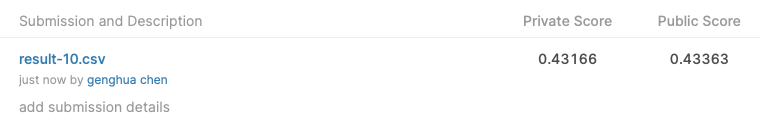

In [ ]:
method3 = X_train.round(2)

At this time, I seleted object and int data types and take a look. there are 24 columns are seleted(includes ID). Which means that there are 4 columns can be consider as categorical columns(not include ID column, because ID column just a unique variables, it's not meaningful).

In [ ]:
categorical_f = method3.select_dtypes(include=['int', 'object']).columns.to_list()[1:]

In [ ]:
# 24 categorical features(ID is one of them)
method3[categorical_f] = method3[categorical_f].astype(str)
method3.head(3)

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,...,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1.34,8.73,C,3.92,7.92,2.60,3.18,0.01,10.00,0.50,16.43,6.09,2.87,11.64,1.36,8.57,3.67,0.11,0.15,18.87,7.73,XDX,-0.0,C,0.14,1.72,3.39,0.59,8.88,C,A,1.08,1.01,7.27,8.38,11.33,0.45,0,4.01,...,0.44,5.81,3.52,0.46,7.44,5.45,8.88,1.19,19.47,8.39,2.76,4.37,1.57,0.01,12.58,E,2.38,3.93,B,0.43,O,nan,15.63,2.86,1.95,6.59,5.91,-0.0,1.06,0.80,8.00,1.99,0.04,AU,1.80,3.11,2.02,0,0.64,2.86
1,4,NaN,NaN,C,NaN,9.19,NaN,NaN,2.30,NaN,1.31,NaN,6.51,NaN,11.64,NaN,NaN,NaN,NaN,NaN,NaN,6.76,GUV,NaN,C,3.06,NaN,NaN,NaN,NaN,C,A,NaN,NaN,3.62,NaN,14.58,NaN,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.30,NaN,NaN,NaN,NaN,NaN,NaN,1.51,NaN,B,1.83,4.25,A,NaN,U,G,10.31,NaN,NaN,10.60,NaN,NaN,NaN,NaN,NaN,NaN,0.60,AF,NaN,NaN,1.96,0,NaN,NaN
2,5,0.94,5.31,C,4.41,5.33,3.98,3.93,0.02,12.67,0.77,14.76,6.38,2.51,9.60,1.98,5.88,3.17,0.24,0.14,17.95,5.25,FQ,-0.0,E,0.11,2.24,5.31,0.84,7.50,nan,A,1.45,1.73,4.04,7.96,12.73,0.26,0,7.38,...,0.27,5.16,4.21,0.31,5.66,5.97,11.59,0.84,15.49,5.88,3.29,5.92,1.67,0.01,11.67,C,1.38,1.18,B,3.37,S,nan,11.21,12.94,3.13,3.48,6.23,-0.0,2.14,2.24,9.33,2.48,0.01,AE,1.77,3.92,1.12,2,0.88,1.18


In [ ]:
cat_features = [X_train.columns.get_loc(col) for col in categorical_f]
len(cat_features)

23

I identified orinal categorical columns as categorical columns, and do select_features again. I changed param 'num_features_to_select' at this time, the reason is I tried lower number, and the loss plot shows I cannot delete that much columns, so this time I just keep 100.

After looking at the results, I found that the loss value starts to increase when v74 is eliminated.

In [ ]:
params = {
          'verbose': 200, 
          'random_seed': 72,
          'cat_features': cat_features,
          }
cat = CatBoostClassifier(**params)

cat.select_features(
                method3,
                y_train,
                eval_set=None,
                features_for_select=method3.columns.to_list(),
                num_features_to_select=100,
                algorithm='RecursiveByLossFunctionChange',
                shap_calc_type = 'Exact',
                train_final_model=False,
                plot = True,
                verbose=200,
                log_cout=sys.stdout,
                log_cerr=sys.stderr)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.077939
Step #1 out of 1
0:	learn: 0.6581762	total: 540ms	remaining: 8m 59s
200:	learn: 0.4468520	total: 1m 45s	remaining: 6m 57s
400:	learn: 0.4351048	total: 3m 29s	remaining: 5m 12s
600:	learn: 0.4265346	total: 5m 15s	remaining: 3m 29s
800:	learn: 0.4182183	total: 7m 4s	remaining: 1m 45s
999:	learn: 0.4110471	total: 8m 54s	remaining: 0us
Feature #80 eliminated
Feature #81 eliminated
Feature #111 eliminated
Feature #72 eliminated
Feature #31 eliminated
Feature #83 eliminated
Feature #114 eliminated
Feature #74 eliminated
Feature #91 eliminated
Feature #25 eliminated
Feature #63 eliminated
Feature #17 eliminated
Feature #23 eliminated
Feature #116 eliminated
Feature #109 eliminated
Feature #108 eliminated
Feature #87 eliminated
Feature #101 eliminated
Feature #84 eliminated
Feature #98 eliminated
Feature #117 eliminated
Feature #43 eliminated
Feature #106 eliminated
Feature #92 eliminated
Feature #41 eliminated
Feature #44 eliminated
Feature #11 eliminated
Feature

{'eliminated_features': [80,
  81,
  111,
  72,
  31,
  83,
  114,
  74,
  91,
  25,
  63,
  17,
  23,
  116,
  109,
  108,
  87,
  101,
  84,
  98,
  117,
  43,
  106,
  92,
  41,
  44,
  11,
  51,
  105,
  26,
  16,
  95],
 'eliminated_features_names': ['v80',
  'v81',
  'v111',
  'v72',
  'v31',
  'v83',
  'v114',
  'v74',
  'v91',
  'v25',
  'v63',
  'v17',
  'v23',
  'v116',
  'v109',
  'v108',
  'v87',
  'v101',
  'v84',
  'v98',
  'v117',
  'v43',
  'v106',
  'v92',
  'v41',
  'v44',
  'v11',
  'v51',
  'v105',
  'v26',
  'v16',
  'v95'],
 'loss_graph': {'loss_values': [0.31418344781087826,
   0.30980375084902717,
   0.309086860143598,
   0.30838470148507946,
   0.3077475533625348,
   0.3075191560073133,
   0.3073612829260167,
   0.3072582287049019,
   0.307182025360003,
   0.30720963387096756,
   0.30724645240781256,
   0.30728996033915795,
   0.30733538025977913,
   0.30738324717107735,
   0.3074357328175828,
   0.30749335078761963,
   0.3075512880453403,
   0.3076095696848051

So, I eliminated 'v80', 'v81', 'v111', 'v72', 'v31','v84', 'v114', 'v74' columns.

In [ ]:
m3_drop = ['v80', 'v81', 'v111', 'v72', 'v31','v84', 'v114', 'v74']
method3 = method3.drop(columns=m3_drop)

After eliminations, there are still 20 categorical features left, so I do the same as method 2, get the features interation and make predictions.

In [ ]:
cat_features_ls = method3.select_dtypes(include=['object'])
cat_features = [method3.columns.get_loc(col) for col in cat_features_ls.columns]
len(cat_features)

20

In [ ]:
cat_col_str = cat_features_ls.astype(str)
cat_col_str

,v3,v22,v24,v30,v38,v47,v52,v56,v62,v66,v71,v75,v79,v91,v107,v110,v112,v113,v125,v129
0,C,XDX,C,C,0,C,G,DI,1,C,F,D,E,A,E,B,O,nan,AU,0
1,C,GUV,C,C,0,E,G,DY,2,A,F,D,D,B,B,A,U,G,AF,0
2,C,FQ,E,nan,0,C,F,AS,1,A,B,B,E,G,C,B,S,nan,AE,2
3,C,ACUE,D,C,0,C,H,BW,1,A,F,D,B,B,B,B,J,nan,CJ,1
4,C,HIT,E,nan,0,I,H,nan,1,C,F,D,C,G,C,A,T,G,Z,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,C,ADQC,E,nan,0,I,E,N,1,A,B,B,C,A,E,A,U,G,AL,0
114317,C,XRT,D,nan,0,C,I,BW,1,A,F,D,B,G,C,B,J,nan,E,1
114318,C,AGTG,A,C,0,C,D,BW,1,A,B,B,B,G,C,B,R,nan,Q,2
114319,C,SGB,D,G,0,C,J,AS,1,A,F,D,E,A,E,B,A,nan,BW,0


In [ ]:
cat_ls = cat_features_ls.columns.to_list()

for j in range(len(cat_ls)):

  for i in cat_ls[j+1:]:

    newnew_col_name = cat_ls[j] + '_' + i
    # if j != i:
    cat_col_str[newnew_col_name] = cat_col_str[cat_ls[j]] + cat_col_str[i]
    # else:
      # pass


In [ ]:
for i in cat_col_str.columns:
  method3[i] = cat_col_str[i]

method3.head(5)

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v32,v33,v34,v35,v36,v37,v38,v39,v40,...,v71_v112,v71_v113,v71_v125,v71_v129,v75_v79,v75_v91,v75_v107,v75_v110,v75_v112,v75_v113,v75_v125,v75_v129,v79_v91,v79_v107,v79_v110,v79_v112,v79_v113,v79_v125,v79_v129,v91_v107,v91_v110,v91_v112,v91_v113,v91_v125,v91_v129,v107_v110,v107_v112,v107_v113,v107_v125,v107_v129,v110_v112,v110_v113,v110_v125,v110_v129,v112_v113,v112_v125,v112_v129,v113_v125,v113_v129,v125_v129
0,3,1.34,8.73,C,3.92,7.92,2.60,3.18,0.01,10.00,0.50,16.43,6.09,2.87,11.64,1.36,8.57,3.67,0.11,0.15,18.87,7.73,XDX,-0.0,C,0.14,1.72,3.39,0.59,8.88,C,1.08,1.01,7.27,8.38,11.33,0.45,0,4.01,7.71,...,FO,Fnan,FAU,F0,DE,DA,DE,DB,DO,Dnan,DAU,D0,EA,EE,EB,EO,Enan,EAU,E0,AE,AB,AO,Anan,AAU,A0,EB,EO,Enan,EAU,E0,BO,Bnan,BAU,B0,Onan,OAU,O0,nanAU,nan0,AU0
1,4,NaN,NaN,C,NaN,9.19,NaN,NaN,2.30,NaN,1.31,NaN,6.51,NaN,11.64,NaN,NaN,NaN,NaN,NaN,NaN,6.76,GUV,NaN,C,3.06,NaN,NaN,NaN,NaN,C,NaN,NaN,3.62,NaN,14.58,NaN,0,NaN,14.31,...,FU,FG,FAF,F0,DD,DB,DB,DA,DU,DG,DAF,D0,DB,DB,DA,DU,DG,DAF,D0,BB,BA,BU,BG,BAF,B0,BA,BU,BG,BAF,B0,AU,AG,AAF,A0,UG,UAF,U0,GAF,G0,AF0
2,5,0.94,5.31,C,4.41,5.33,3.98,3.93,0.02,12.67,0.77,14.76,6.38,2.51,9.60,1.98,5.88,3.17,0.24,0.14,17.95,5.25,FQ,-0.0,E,0.11,2.24,5.31,0.84,7.50,nan,1.45,1.73,4.04,7.96,12.73,0.26,0,7.38,13.08,...,BS,Bnan,BAE,B2,BE,BG,BC,BB,BS,Bnan,BAE,B2,EG,EC,EB,ES,Enan,EAE,E2,GC,GB,GS,Gnan,GAE,G2,CB,CS,Cnan,CAE,C2,BS,Bnan,BAE,B2,Snan,SAE,S2,nanAE,nan2,AE2
3,6,0.80,8.30,C,4.23,11.63,2.10,1.99,0.17,8.97,6.54,16.35,9.65,3.90,14.09,1.95,5.52,3.61,1.22,0.23,18.38,7.52,ACUE,-0.0,D,0.15,1.31,2.30,8.93,8.87,C,1.59,1.67,8.70,8.90,11.30,0.43,0,0.29,11.52,...,FJ,Fnan,FCJ,F1,DB,DB,DB,DB,DJ,Dnan,DCJ,D1,BB,BB,BB,BJ,Bnan,BCJ,B1,BB,BB,BJ,Bnan,BCJ,B1,BB,BJ,Bnan,BCJ,B1,BJ,Bnan,BCJ,B1,Jnan,JCJ,J1,nanCJ,nan1,CJ1
4,8,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.05,NaN,6.32,NaN,10.99,NaN,NaN,NaN,NaN,NaN,NaN,6.41,HIT,NaN,E,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,6.08,NaN,NaN,NaN,0,NaN,10.14,...,FT,FG,FZ,F0,DC,DG,DC,DA,DT,DG,DZ,D0,CG,CC,CA,CT,CG,CZ,C0,GC,GA,GT,GG,GZ,G0,CA,CT,CG,CZ,C0,AT,AG,AZ,A0,TG,TZ,T0,GZ,G0,Z0


I had added 210 categorical columns this time, which less than method 2, the difference is that the method 2 I didn't considered sumation of same column, like v3_v3. so I modified the code a bit. The reason is that if I still use the code from method 2, it will return more than 500 new columns, which cause my model to run about 5 hours to complete modeling. I don't think it's necessary. However, if the result do not meet my expect, I will try the previous one.

In [ ]:
cat_col = method3.select_dtypes(include=[object])
cat_features = [method3.columns.get_loc(col) for col in cat_col.columns]
len(cat_features)

210

In [ ]:
params = {
          'verbose': 200, 
          'random_seed': 72,
          'cat_features': cat_features,
          'iterations': 2000,
          }
cat = CatBoostClassifier(**params)


cat.fit(method3, y_train,
        use_best_model=True,
         )
print(cat.get_best_score())

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.041277
0:	learn: 0.6743816	total: 3.89s	remaining: 2h 9m 38s
200:	learn: 0.4502597	total: 13m 42s	remaining: 2h 2m 40s
400:	learn: 0.4427315	total: 28m 21s	remaining: 1h 53m 6s
600:	learn: 0.4378524	total: 42m 54s	remaining: 1h 39m 51s
800:	learn: 0.4340223	total: 57m 20s	remaining: 1h 25m 49s
1000:	learn: 0.4307324	total: 1h 11m 40s	remaining: 1h 11m 32s
1200:	learn: 0.4274502	total: 1h 26m 3s	remaining: 57m 15s
1400:	learn: 0.4241902	total: 1h 40m 19s	remaining: 42m 53s
1600:	learn: 0.4211581	total: 1h 54m 51s	remaining: 28m 37s
1800:	learn: 0.4180640	total: 2h 9m 27s	remaining: 14m 18s
1999:	learn: 0.4152184	total: 2h 23m 56s	remaining: 0us
{'learn': {'Logloss': 0.4152183501174989}}


In [ ]:
dump(cat, '/content/BNP.joblib')

['/content/BNP.joblib']

Here I just make sure the format of test set same as train set.

In [ ]:
test = test.round(2)
test3 = test.drop(columns=m3_drop)
cat_features_ls_test = test3.select_dtypes(include=['object','int'])
cat_features = [test3.columns.get_loc(col) for col in cat_features_ls_test.columns]
cat_col_str = cat_features_ls_test.astype(str)
cat_col_str

,v3,v22,v24,v30,v47,v52,v56,v66,v71,v75,v79,v91,v107,v110,v112,v113,v125
0,C,AFPB,E,nan,J,C,AF,A,F,D,Q,B,B,A,U,nan,AF
1,C,FOG,D,A,C,A,DI,C,F,D,E,C,D,B,E,nan,I
2,C,HXZ,B,C,I,A,DO,C,F,D,C,C,D,A,Q,AJ,AV
3,C,AGMU,E,E,I,A,CN,B,F,D,C,B,B,A,F,G,B
4,C,AWW,E,C,I,H,nan,B,F,D,C,B,B,A,A,I,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114388,C,ADRO,D,nan,I,G,BX,C,B,B,C,B,B,A,A,P,AG
114389,C,TFN,D,nan,I,H,DX,A,F,D,I,C,D,A,P,AJ,H
114390,C,YOD,C,C,C,K,BZ,B,B,B,E,F,A,B,A,nan,V
114391,C,AGDF,E,nan,C,I,BV,C,F,D,B,G,C,B,F,nan,AZ


In [ ]:
test = test.round(2)
test3 = test.drop(columns=m3_drop)
cat_col_test = test3.select_dtypes(include=['object', 'int']).drop(columns=['ID'])
# cat_features = [test3.columns.get_loc(col) for col in cat_col_test.columns]
cat_ls = cat_col_test.columns.to_list()
cat_col_str = cat_col_test.astype(str)
cat_col_str

,v3,v22,v24,v30,v38,v47,v52,v56,v62,v66,v71,v75,v79,v91,v107,v110,v112,v113,v125,v129
0,C,AFPB,E,nan,0,J,C,AF,1,A,F,D,Q,B,B,A,U,nan,AF,0
1,C,FOG,D,A,4,C,A,DI,1,C,F,D,E,C,D,B,E,nan,I,0
2,C,HXZ,B,C,0,I,A,DO,1,C,F,D,C,C,D,A,Q,AJ,AV,0
3,C,AGMU,E,E,0,I,A,CN,1,B,F,D,C,B,B,A,F,G,B,0
4,C,AWW,E,C,0,I,H,nan,2,B,F,D,C,B,B,A,A,I,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114388,C,ADRO,D,nan,0,I,G,BX,1,C,B,B,C,B,B,A,A,P,AG,0
114389,C,TFN,D,nan,0,I,H,DX,3,A,F,D,I,C,D,A,P,AJ,H,0
114390,C,YOD,C,C,0,C,K,BZ,1,B,B,B,E,F,A,B,A,nan,V,0
114391,C,AGDF,E,nan,0,C,I,BV,1,C,F,D,B,G,C,B,F,nan,AZ,0


In [ ]:


for j in range(len(cat_ls)):

  for i in cat_ls[j+1:]:

    newnew_col_name = cat_ls[j] + '_' + i
    # if j != i:
    cat_col_str[newnew_col_name] = cat_col_str[cat_ls[j]] + cat_col_str[i]
    # else:
      # pass

In [ ]:
for i in cat_col_str.columns:
  test3[i] = cat_col_str[i]

test3.head(5)

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v32,v33,v34,v35,v36,v37,v38,v39,v40,...,v71_v112,v71_v113,v71_v125,v71_v129,v75_v79,v75_v91,v75_v107,v75_v110,v75_v112,v75_v113,v75_v125,v75_v129,v79_v91,v79_v107,v79_v110,v79_v112,v79_v113,v79_v125,v79_v129,v91_v107,v91_v110,v91_v112,v91_v113,v91_v125,v91_v129,v107_v110,v107_v112,v107_v113,v107_v125,v107_v129,v110_v112,v110_v113,v110_v125,v110_v129,v112_v113,v112_v125,v112_v129,v113_v125,v113_v129,v125_v129
0,0,1.38,11.36,C,4.20,6.58,2.08,1.78,0.01,9.52,1.31,16.85,6.96,3.11,12.23,1.77,2.86,3.49,0.10,0.23,17.91,7.44,AFPB,0.0,E,0.07,0.95,4.39,0.57,6.99,nan,1.12,2.08,5.23,8.18,12.18,0.83,0,2.84,11.75,...,FU,Fnan,FAF,F0,DQ,DB,DB,DA,DU,Dnan,DAF,D0,QB,QB,QA,QU,Qnan,QAF,Q0,BB,BA,BU,Bnan,BAF,B0,BA,BU,Bnan,BAF,B0,AU,Anan,AAF,A0,Unan,UAF,U0,nanAF,nan0,AF0
1,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.29,NaN,6.62,NaN,10.76,NaN,NaN,NaN,NaN,NaN,NaN,5.90,FOG,NaN,D,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,8.39,NaN,NaN,NaN,4,NaN,6.74,...,FE,Fnan,FI,F0,DE,DC,DD,DB,DE,Dnan,DI,D0,EC,ED,EB,EE,Enan,EI,E0,CD,CB,CE,Cnan,CI,C0,DB,DE,Dnan,DI,D0,BE,Bnan,BI,B0,Enan,EI,E0,nanI,nan0,I0
2,2,-0.00,8.20,C,4.54,6.55,1.56,2.47,0.01,7.14,1.58,15.14,6.89,1.90,13.31,1.30,3.33,3.18,0.07,0.17,17.54,8.25,HXZ,-0.0,B,0.06,2.86,2.21,0.33,8.31,C,0.97,1.56,7.96,8.31,12.20,-0.00,0,6.71,7.70,...,FQ,FAJ,FAV,F0,DC,DC,DD,DA,DQ,DAJ,DAV,D0,CC,CD,CA,CQ,CAJ,CAV,C0,CD,CA,CQ,CAJ,CAV,C0,DA,DQ,DAJ,DAV,D0,AQ,AAJ,AAV,A0,QAJ,QAV,Q0,AJAV,AJ0,AV0
3,7,2.66,3.04,C,1.66,9.77,2.08,1.43,1.25,7.96,1.58,14.42,6.86,5.09,10.40,2.80,7.30,1.12,0.61,0.48,15.29,5.54,AGMU,0.0,E,1.78,1.41,1.35,5.35,6.47,E,2.36,3.85,6.22,6.63,13.74,2.01,0,0.00,10.44,...,FF,FG,FB,F0,DC,DB,DB,DA,DF,DG,DB,D0,CB,CB,CA,CF,CG,CB,C0,BB,BA,BF,BG,BB,B0,BA,BF,BG,BB,B0,AF,AG,AB,A0,FG,FB,F0,GB,G0,B0
4,10,1.25,11.28,C,4.64,8.52,2.30,3.51,0.07,7.61,1.05,15.59,6.27,2.50,11.35,1.35,3.02,4.97,0.53,0.15,18.67,6.74,AWW,-0.0,E,0.16,2.59,3.26,3.79,8.86,C,1.00,1.20,5.48,7.74,10.81,0.39,0,0.49,11.10,...,FA,FI,FA,F0,DC,DB,DB,DA,DA,DI,DA,D0,CB,CB,CA,CA,CI,CA,C0,BB,BA,BA,BI,BA,B0,BA,BA,BI,BA,B0,AA,AI,AA,A0,AI,AA,A0,IA,I0,A0


In [ ]:
# result10
preds_proba = cat.predict_proba(test3)
# pred = cat.predict(X_test_enc)
df = pd.DataFrame(preds_proba, columns = ['2', 'PredictedProb'])
df['ID'] = test['ID']
df = df.drop(columns=['2'])
df = df[['ID', 'PredictedProb']]
df.to_csv('result.csv', index=False)

In [ ]:
df

,ID,PredictedProb
0,0,0.183065
1,1,0.917025
2,2,0.858286
3,7,0.754842
4,10,0.804808
...,...,...
114388,228700,0.899832
114389,228703,0.054030
114390,228704,0.870553
114391,228706,0.915323


# Conclusion

In conclusion, this dataset was featured prediction competition 5 years ago from BNP. The tech are developing rapidly, Catboost Classifier is the newest classifier, so I think it can beats those old stuff, and the result comfirmed my belief. At first I tried different classifier as well, such as Random forest, logistic regression classifier, but the log-loss not even close to 60%, some of them even far away from 60%, the reason might be that the algorithm of classifier just can not do well on this dataset. During the data exploration, what I found was that categorical columns were very powerful for predictions, so I focus more on categorical columns and as expect, and I got the good prediction. 

# Try

## Method 3 Simple imputation:0.48066

In [ ]:
def to_df(name, df):
  name = pd.DataFrame(name)
  name.columns=df.columns
  name.index=df.index
  return name

In [ ]:
method_2 = X_train.round(2)

In [ ]:
imp_mean = SimpleImputer(strategy='most_frequent')
X_train_simple = imp_mean.fit_transform(method_2)

In [ ]:
X_train_simple = to_df(X_train_simple, method_2)
X_train_simple.head(5)

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,...,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1.34,8.73,C,3.92,7.92,2.6,3.18,0.01,10,0.5,16.43,6.09,2.87,11.64,1.36,8.57,3.67,0.11,0.15,18.87,7.73,XDX,-0,C,0.14,1.72,3.39,0.59,8.88,C,A,1.08,1.01,7.27,8.38,11.33,0.45,0,4.01,...,0.44,5.81,3.52,0.46,7.44,5.45,8.88,1.19,19.47,8.39,2.76,4.37,1.57,0.01,12.58,E,2.38,3.93,B,0.43,O,G,15.63,2.86,1.95,6.59,5.91,-0,1.06,0.8,8,1.99,0.04,AU,1.8,3.11,2.02,0,0.64,2.86
1,4,0,5.92,C,4.29,9.19,2.41,2.22,2.3,10,1.31,15.69,6.51,3.32,11.64,1.76,5,3.42,0.72,0.18,18.39,6.76,GUV,-0,C,3.06,1.66,2.39,4.58,8.3,C,A,1.51,1.44,3.62,7.79,14.58,-0,0,0,...,0.55,5.31,3.78,0.55,6.29,6.67,8.3,1.23,0,6.99,2.52,4.58,2.49,1.51,12.39,B,1.83,4.25,A,2.8,U,G,10.31,10,2.13,10.6,6.67,-0,0.93,2.25,6.67,2.23,0.6,AF,1.54,2.59,1.96,0,1.33,0
2,5,0.94,5.31,C,4.41,5.33,3.98,3.93,0.02,12.67,0.77,14.76,6.38,2.51,9.6,1.98,5.88,3.17,0.24,0.14,17.95,5.25,FQ,-0,E,0.11,2.24,5.31,0.84,7.5,C,A,1.45,1.73,4.04,7.96,12.73,0.26,0,7.38,...,0.27,5.16,4.21,0.31,5.66,5.97,11.59,0.84,15.49,5.88,3.29,5.92,1.67,0.01,11.67,C,1.38,1.18,B,3.37,S,G,11.21,12.94,3.13,3.48,6.23,-0,2.14,2.24,9.33,2.48,0.01,AE,1.77,3.92,1.12,2,0.88,1.18
3,6,0.8,8.3,C,4.23,11.63,2.1,1.99,0.17,8.97,6.54,16.35,9.65,3.9,14.09,1.95,5.52,3.61,1.22,0.23,18.38,7.52,ACUE,-0,D,0.15,1.31,2.3,8.93,8.87,C,B,1.59,1.67,8.7,8.9,11.3,0.43,0,0.29,...,0.76,5.5,3.42,0.83,7.38,6.75,6.94,1.33,18.26,8.51,2.5,4.87,2.57,0.11,12.55,B,2.23,1.99,B,2.64,J,G,13.78,10.57,1.51,4.95,7.18,0.57,1.17,1.96,7.02,1.81,0,CJ,1.42,2.95,1.99,1,1.68,1.03
4,8,0,5.92,C,4.29,11.14,2.41,2.22,0.02,10,1.05,15.69,6.32,3.32,10.99,1.76,5,3.42,0.72,0.18,18.39,6.41,HIT,-0,E,0.15,1.66,2.39,4.58,8.3,C,A,1.51,1.44,6.08,7.79,6.03,-0,0,0,...,0.55,5.31,3.78,0.55,6.29,6.67,8.31,1.23,0,6.99,2.52,4.58,2.49,0.01,12.39,C,1.35,0,A,2.8,T,G,14.1,10,2.13,-0,6.67,-0,0.93,2.25,6.67,2.23,0,Z,1.54,2.59,1.42,0,1.33,0


In [ ]:
X_train_simple.dtypes

ID      object
v1      object
v2      object
v3      object
v4      object
         ...  
v127    object
v128    object
v129    object
v130    object
v131    object
Length: 132, dtype: object

In [ ]:
# X_train_simple = pd.DataFrame(X_train_simple)
# X_train_simple.columns=X_train.columns
# X_train_simple.index=X_train.index
# X_train_simple.head(5)

In [ ]:
cat_col = X_train.select_dtypes(include=[object])
cat_col

,v3,v22,v24,v30,v31,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,C,XDX,C,C,A,C,G,DI,C,F,B,D,E,A,E,B,O,NaN,AU
1,C,GUV,C,C,A,E,G,DY,A,F,B,D,D,B,B,A,U,G,AF
2,C,FQ,E,NaN,A,C,F,AS,A,B,B,B,E,G,C,B,S,NaN,AE
3,C,ACUE,D,C,B,C,H,BW,A,F,B,D,B,B,B,B,J,NaN,CJ
4,C,HIT,E,NaN,A,I,H,NaN,C,F,B,D,C,G,C,A,T,G,Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,C,ADQC,E,NaN,A,I,E,N,A,B,B,B,C,A,E,A,U,G,AL
114317,C,XRT,D,NaN,B,C,I,BW,A,F,B,D,B,G,C,B,J,NaN,E
114318,C,AGTG,A,C,B,C,D,BW,A,B,B,B,B,G,C,B,R,NaN,Q
114319,C,SGB,D,G,A,C,J,AS,A,F,B,D,E,A,E,B,A,NaN,BW


In [ ]:
cat_col = X_train.select_dtypes(include=[object])
ord = OrdinalEncoder()
X_train_cat = X_train_simple[cat_col.columns.to_list()]
X_train_simple_with_ord = ord.fit_transform(X_train_cat)
X_train_simple_with_ord = to_df(X_train_simple_with_ord, X_train_cat)
X_train_simple_with_ord.head(5)

,v3,v22,v24,v30,v31,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,2.0,16670.0,2.0,2.0,0.0,2.0,6.0,85.0,2.0,4.0,1.0,3.0,4.0,0.0,4.0,1.0,14.0,17.0,21.0
1,2.0,7733.0,2.0,2.0,0.0,4.0,6.0,101.0,0.0,4.0,1.0,3.0,3.0,1.0,1.0,0.0,20.0,17.0,6.0
2,2.0,7086.0,4.0,2.0,0.0,2.0,5.0,17.0,0.0,1.0,1.0,1.0,4.0,6.0,2.0,1.0,18.0,17.0,5.0
3,2.0,1510.0,3.0,2.0,1.0,2.0,7.0,47.0,0.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,9.0,17.0,64.0
4,2.0,8037.0,4.0,2.0,0.0,8.0,7.0,47.0,2.0,4.0,1.0,3.0,2.0,6.0,2.0,0.0,19.0,17.0,89.0


In [ ]:
# X_train_simple_with_ord = pd.DataFrame(X_train_simple_with_ord)
# X_train_simple_with_ord.columns=X_train_cat.columns
# X_train_simple_with_ord.index=X_train_cat.index
# X_train_simple_with_ord.head(5)

In [ ]:
X_test_simple = imp_mean.fit_transform(test)
X_test_simple = to_df(X_test_simple, test)
X_test_cat = X_test_simple[cat_col.columns.to_list()]
X_test_simple_with_ord = ord.fit_transform(X_test_cat)
X_test_simple_with_ord = to_df(X_test_simple_with_ord, X_test_cat)
for i in X_test_simple_with_ord.columns:
  X_test_simple[i] = X_test_simple_with_ord[i]

X_test_simple.head(5)

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,...,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,0,1.37547,11.3611,2.0,4.20078,6.577,2.08178,1.78439,0.011094,9.52381,1.31291,16.8519,6.96117,3.10746,12.2301,1.77305,2.85714,3.49382,0.0968257,0.225481,17.9102,7.43781,3040.0,9.55831e-07,4.0,0.0691803,0.954152,4.38662,0.573017,6.98885,2.0,0.0,1.11524,2.08178,5.2285,8.17844,12.1832,0.833334,0,2.84277,...,0.658269,4.9293,2.99237,0.759955,5.94795,5,10.0135,0.817844,19.708,4.18679,1.87394,4.12902,1.70189,0.00453471,11.6881,1.0,1.50248,2.12171,0.0,3.56877,20.0,16.0,12.2467,11.4286,1.2766,4.7779,5.83333,-9.97495e-07,1.45985,3.26733,7.61905,1.81524,1.11227e-07,6.0,1.29237,3.90335,1.48593,0,2.33333,1.42857
1,1,1.21444,11.3317,2.0,-1.22521e-08,6.1485,-9.8733e-07,2.45828,1.26525,8.26229,1.29103,14.7844,6.61829,2.80346,10.7608,1.78507,3.33333,2.9177,0.674253,0.0237341,15.1962,5.89519,7094.0,12.7364,3.0,1.96757,1.9896,0.900169,1.82382,8.45508,0.0,0.0,1.19522,2.09024,8.38743,7.01478,6.03212,0.540541,4,-9.99173e-07,...,0.0087584,12.2746,-7.72552e-07,0.00863661,5.56177,7.23404,6.80003,-9.75182e-07,20,-8.9896e-07,1.24483,-7.92185e-07,2.90257,1.80925,10.3105,3.0,1.44681,0.562831,1.0,-9.88208e-07,4.0,16.0,16.2849,10,2.96482,14.7592,6.66667,3.72613,-9.89953e-07,1.75,5.71428,7.84338e-07,5.11101,72.0,1.73824,3.04286,1.02642,0,1.4,0.969162
2,2,-4.90341e-07,8.20153,2.0,4.54437,6.5501,1.55844,2.46753,0.00716367,7.14286,1.57549,15.1429,6.89425,1.89979,13.3062,1.30208,3.33333,3.17741,0.0706761,0.172391,17.5375,8.25345,8384.0,-2.13722e-07,1.0,0.0596196,2.85714,2.20779,0.327134,8.31169,2.0,0.0,0.974026,1.55844,7.95899,8.31169,12.1951,-5.24933e-07,0,6.70735,...,0.552642,4.35098,3.16366,0.604966,6.23377,12.6316,10.2146,0.95238,19.8,6.53556,0.762963,4.91753,1.98186,0.00279355,11.747,3.0,1.18877,2.08882,0.0,3.11688,16.0,10.0,15.6227,13.3333,3.75,4.74057,12.6316,4.91066e-08,0.6,2.5,5.71429,1.97093,0.0141226,22.0,1.12872,5.84416,1.47589,0,1.26316,-6.38002e-07
3,7,2.66187,3.04124,2.0,1.65722,9.77308,2.07834,1.43085,1.25216,7.9596,1.57549,14.4244,6.85624,5.0866,10.397,2.8035,7.3029,1.12198,0.608524,0.476554,15.2856,5.53948,3540.0,5.8634e-07,4.0,1.77999,1.40687,1.35092,5.34744,6.47482,4.0,0.0,2.36211,3.85292,6.22385,6.63469,13.7419,2.01117,0,8.24889e-07,...,0.775499,3.1762,5.07134,1.02053,4.98002,8.60335,5.74359,0.688783,0.116143,3.62766,1.24483,7.48623,4.31304,1.04864,5.95708,1.0,2.69087,6.2116,0.0,3.93285,5.0,16.0,13.7016,6.80498,1.90123,12.4461,10.7263,18.2448,2.32288,4.14959,4.40404,8.16361,1.10033,27.0,1.98869,1.55875,2.44881,0,5.38547,1.49378
4,10,1.25282,11.2834,2.0,4.63839,8.52051,2.30248,3.51016,0.0742633,7.6129,1.05033,15.59,6.27363,2.50017,11.3545,1.3535,3.01887,4.97403,0.530779,0.148821,18.6695,6.74153,4540.0,-2.72503e-07,4.0,0.158719,2.58653,3.26185,3.78662,8.86005,2.0,0.0,0.998871,1.19639,5.47686,7.74266,10.815,0.385851,0,0.489777,...,0.389974,5.63214,3.88511,0.417548,6.94131,7.65273,8.58922,1.076,19.2277,6.60679,1.49388,4.929,1.90692,0.0551341,14.667,1.0,2.46702,5.3125,0.0,1.82844,0.0,18.0,13.3954,10.1887,3.03185,7.63718,8.03859,0.662672,0.852197,1.67622,6.58064,1.32565,0.258459,0.0,1.8638,2.66648,2.37427,0,0.681672,2.26415


In [ ]:
for i in X_train_simple_with_ord.columns:
  X_train_simple[i] = X_train_simple_with_ord[i]

X_train_simple.head(5)

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,...,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1.34,8.73,2.0,3.92,7.92,2.6,3.18,0.01,10,0.5,16.43,6.09,2.87,11.64,1.36,8.57,3.67,0.11,0.15,18.87,7.73,16670.0,-0,2.0,0.14,1.72,3.39,0.59,8.88,2.0,0.0,1.08,1.01,7.27,8.38,11.33,0.45,0,4.01,...,0.44,5.81,3.52,0.46,7.44,5.45,8.88,1.19,19.47,8.39,2.76,4.37,1.57,0.01,12.58,4.0,2.38,3.93,1.0,0.43,14.0,17.0,15.63,2.86,1.95,6.59,5.91,-0,1.06,0.8,8,1.99,0.04,21.0,1.8,3.11,2.02,0,0.64,2.86
1,4,0,5.92,2.0,4.29,9.19,2.41,2.22,2.3,10,1.31,15.69,6.51,3.32,11.64,1.76,5,3.42,0.72,0.18,18.39,6.76,7733.0,-0,2.0,3.06,1.66,2.39,4.58,8.3,2.0,0.0,1.51,1.44,3.62,7.79,14.58,-0,0,0,...,0.55,5.31,3.78,0.55,6.29,6.67,8.3,1.23,0,6.99,2.52,4.58,2.49,1.51,12.39,1.0,1.83,4.25,0.0,2.8,20.0,17.0,10.31,10,2.13,10.6,6.67,-0,0.93,2.25,6.67,2.23,0.6,6.0,1.54,2.59,1.96,0,1.33,0
2,5,0.94,5.31,2.0,4.41,5.33,3.98,3.93,0.02,12.67,0.77,14.76,6.38,2.51,9.6,1.98,5.88,3.17,0.24,0.14,17.95,5.25,7086.0,-0,4.0,0.11,2.24,5.31,0.84,7.5,2.0,0.0,1.45,1.73,4.04,7.96,12.73,0.26,0,7.38,...,0.27,5.16,4.21,0.31,5.66,5.97,11.59,0.84,15.49,5.88,3.29,5.92,1.67,0.01,11.67,2.0,1.38,1.18,1.0,3.37,18.0,17.0,11.21,12.94,3.13,3.48,6.23,-0,2.14,2.24,9.33,2.48,0.01,5.0,1.77,3.92,1.12,2,0.88,1.18
3,6,0.8,8.3,2.0,4.23,11.63,2.1,1.99,0.17,8.97,6.54,16.35,9.65,3.9,14.09,1.95,5.52,3.61,1.22,0.23,18.38,7.52,1510.0,-0,3.0,0.15,1.31,2.3,8.93,8.87,2.0,1.0,1.59,1.67,8.7,8.9,11.3,0.43,0,0.29,...,0.76,5.5,3.42,0.83,7.38,6.75,6.94,1.33,18.26,8.51,2.5,4.87,2.57,0.11,12.55,1.0,2.23,1.99,1.0,2.64,9.0,17.0,13.78,10.57,1.51,4.95,7.18,0.57,1.17,1.96,7.02,1.81,0,64.0,1.42,2.95,1.99,1,1.68,1.03
4,8,0,5.92,2.0,4.29,11.14,2.41,2.22,0.02,10,1.05,15.69,6.32,3.32,10.99,1.76,5,3.42,0.72,0.18,18.39,6.41,8037.0,-0,4.0,0.15,1.66,2.39,4.58,8.3,2.0,0.0,1.51,1.44,6.08,7.79,6.03,-0,0,0,...,0.55,5.31,3.78,0.55,6.29,6.67,8.31,1.23,0,6.99,2.52,4.58,2.49,0.01,12.39,2.0,1.35,0,0.0,2.8,19.0,17.0,14.1,10,2.13,-0,6.67,-0,0.93,2.25,6.67,2.23,0,89.0,1.54,2.59,1.42,0,1.33,0


In [ ]:
X_train_simple = X_train_simple.astype(float)
X_train_simple[cat_col.columns] = X_train_simple[cat_col.columns].astype(str)
X_train_simple.dtypes

ID      float64
v1      float64
v2      float64
v3       object
v4      float64
         ...   
v127    float64
v128    float64
v129    float64
v130    float64
v131    float64
Length: 132, dtype: object

In [ ]:
params = {
          # "eval_metric": "TotalF1:average=Macro",
          'verbose': 200, 
          'random_seed': 72,
          'cat_features': cat_features,
          # 'nan_mode': 'Min',
          }
cat = CatBoostClassifier(**params)

cat.select_features(
                X_train_simple,
                y_train,
                eval_set=None,
                features_for_select=col,
                num_features_to_select=30,
                algorithm='RecursiveByLossFunctionChange',
                shap_calc_type = 'Exact',
                train_final_model=False,
                plot = True,
                verbose=200,
                log_cout=sys.stdout,
                log_cerr=sys.stderr)

In [ ]:
drop_med2 = ['v72',
  'v62',
  'v129',
  'v74',
  'v54',
  'v25']

method_2 = X_train_simple.drop(columns=drop_col)
method_2.head(5)

,ID,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v130,v131
0,3.0,1.34,8.73,3.92,7.92,2.60,3.18,0.01,10.00,0.50,16.43,6.09,2.87,11.64,1.36,8.57,3.67,0.11,0.15,18.87,7.73,16670.0,-0.0,2.0,0.14,1.72,3.39,0.59,8.88,2.0,1.08,1.01,7.27,8.38,11.33,0.45,0.0,4.01,7.71,7.65,...,0.0,0.44,5.81,3.52,0.46,7.44,5.45,8.88,1.19,19.47,8.39,2.76,4.37,1.57,0.01,12.58,4.0,2.38,3.93,1.0,0.43,14.0,17.0,15.63,2.86,1.95,6.59,5.91,-0.00,1.06,0.80,8.00,1.99,0.04,21.0,1.80,3.11,2.02,0.64,2.86
1,4.0,0.00,5.92,4.29,9.19,2.41,2.22,2.30,10.00,1.31,15.69,6.51,3.32,11.64,1.76,5.00,3.42,0.72,0.18,18.39,6.76,7733.0,-0.0,2.0,3.06,1.66,2.39,4.58,8.30,2.0,1.51,1.44,3.62,7.79,14.58,-0.00,0.0,0.00,14.31,7.08,...,1.0,0.55,5.31,3.78,0.55,6.29,6.67,8.30,1.23,0.00,6.99,2.52,4.58,2.49,1.51,12.39,1.0,1.83,4.25,0.0,2.80,20.0,17.0,10.31,10.00,2.13,10.60,6.67,-0.00,0.93,2.25,6.67,2.23,0.60,6.0,1.54,2.59,1.96,1.33,0.00
2,5.0,0.94,5.31,4.41,5.33,3.98,3.93,0.02,12.67,0.77,14.76,6.38,2.51,9.60,1.98,5.88,3.17,0.24,0.14,17.95,5.25,7086.0,-0.0,4.0,0.11,2.24,5.31,0.84,7.50,2.0,1.45,1.73,4.04,7.96,12.73,0.26,0.0,7.38,13.08,6.17,...,6.0,0.27,5.16,4.21,0.31,5.66,5.97,11.59,0.84,15.49,5.88,3.29,5.92,1.67,0.01,11.67,2.0,1.38,1.18,1.0,3.37,18.0,17.0,11.21,12.94,3.13,3.48,6.23,-0.00,2.14,2.24,9.33,2.48,0.01,5.0,1.77,3.92,1.12,0.88,1.18
3,6.0,0.80,8.30,4.23,11.63,2.10,1.99,0.17,8.97,6.54,16.35,9.65,3.90,14.09,1.95,5.52,3.61,1.22,0.23,18.38,7.52,1510.0,-0.0,3.0,0.15,1.31,2.30,8.93,8.87,2.0,1.59,1.67,8.70,8.90,11.30,0.43,0.0,0.29,11.52,7.93,...,1.0,0.76,5.50,3.42,0.83,7.38,6.75,6.94,1.33,18.26,8.51,2.50,4.87,2.57,0.11,12.55,1.0,2.23,1.99,1.0,2.64,9.0,17.0,13.78,10.57,1.51,4.95,7.18,0.57,1.17,1.96,7.02,1.81,0.00,64.0,1.42,2.95,1.99,1.68,1.03
4,8.0,0.00,5.92,4.29,11.14,2.41,2.22,0.02,10.00,1.05,15.69,6.32,3.32,10.99,1.76,5.00,3.42,0.72,0.18,18.39,6.41,8037.0,-0.0,4.0,0.15,1.66,2.39,4.58,8.30,2.0,1.51,1.44,6.08,7.79,6.03,-0.00,0.0,0.00,10.14,7.08,...,6.0,0.55,5.31,3.78,0.55,6.29,6.67,8.31,1.23,0.00,6.99,2.52,4.58,2.49,0.01,12.39,2.0,1.35,0.00,0.0,2.80,19.0,17.0,14.10,10.00,2.13,-0.00,6.67,-0.00,0.93,2.25,6.67,2.23,0.00,89.0,1.54,2.59,1.42,1.33,0.00


In [ ]:
cat_col = method_2.select_dtypes(include=[object])
cat_features = [method_2.columns.get_loc(col) for col in cat_col.columns]
len(cat_features)

17

In [ ]:
cat_col

,v22,v24,v30,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,16670.0,2.0,2.0,2.0,6.0,85.0,2.0,4.0,1.0,3.0,4.0,0.0,4.0,1.0,14.0,17.0,21.0
1,7733.0,2.0,2.0,4.0,6.0,101.0,0.0,4.0,1.0,3.0,3.0,1.0,1.0,0.0,20.0,17.0,6.0
2,7086.0,4.0,2.0,2.0,5.0,17.0,0.0,1.0,1.0,1.0,4.0,6.0,2.0,1.0,18.0,17.0,5.0
3,1510.0,3.0,2.0,2.0,7.0,47.0,0.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,9.0,17.0,64.0
4,8037.0,4.0,2.0,8.0,7.0,47.0,2.0,4.0,1.0,3.0,2.0,6.0,2.0,0.0,19.0,17.0,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,1972.0,4.0,2.0,8.0,4.0,110.0,0.0,1.0,1.0,1.0,2.0,0.0,4.0,0.0,20.0,17.0,12.0
114317,16964.0,3.0,2.0,2.0,8.0,47.0,0.0,4.0,1.0,3.0,1.0,6.0,2.0,1.0,9.0,17.0,68.0
114318,3677.0,0.0,2.0,2.0,3.0,47.0,0.0,1.0,1.0,1.0,1.0,6.0,2.0,1.0,17.0,17.0,80.0
114319,13993.0,3.0,6.0,2.0,9.0,17.0,0.0,4.0,1.0,3.0,4.0,0.0,4.0,1.0,0.0,17.0,50.0


In [ ]:
cat_ls = cat_col.columns.to_list()

cat_ls[1:33]

['v22',
 'v24',
 'v30',
 'v47',
 'v52',
 'v56',
 'v66',
 'v71',
 'v74',
 'v75',
 'v79',
 'v91',
 'v107',
 'v110',
 'v112',
 'v113',
 'v125',
 'Diff0',
 'Diff1',
 'Diff2',
 'Diff3',
 'Diff4',
 'Diff5',
 'Diff6',
 'Diff7',
 'Diff8',
 'Diff9',
 'Diff10',
 'Diff11',
 'Diff12',
 'Diff13',
 'Diff14',
 'Diff15']

In [ ]:
cat_col = cat_col.astype(int)
cat_col.dtypes

v22     int64
v24     int64
v30     int64
v47     int64
v52     int64
v56     int64
v66     int64
v71     int64
v74     int64
v75     int64
v79     int64
v91     int64
v107    int64
v110    int64
v112    int64
v113    int64
v125    int64
dtype: object

In [ ]:
num = []
for i in range(100):
  num.append(i)

In [ ]:
# for j in range(len(cat_ls)):
#   len_cat = cat_ls[j:len(cat_ls)]
#   # print(len_cat)
#   for i in range(len(len_cat)):
#     new_len = len_cat[j+1:len(cat_ls)]
#     print(new_len)
    # newnew_col_name = 'Diff' + str(num[i])
    # cat_col[newnew_col_name] = np.where( cat_col[len_cat[j]] == cat_col[new_len[i]] , '1', '0')

for i in range(len(cat_ls)):
  newnew_col_name = 'v22' + cat_ls[i]
  cat_col[newnew_col_name] = np.where( cat_col['v22'] == cat_col[cat_ls[i]] , '1', '0')


cat_col

NameError: ignored

In [ ]:
params = {
          # "eval_metric": "TotalF1:average=Macro",
          'verbose': 200, 
          'random_seed': 72,
          'cat_features': cat_features,
          'iterations': 2000,
          # 'nan_mode': 'Min',
          }
cat = CatBoostClassifier(**params)


cat.fit(method_2, y_train,
        use_best_model=True,
         )
print(cat.get_best_score())

Custom logger is already specified. Specify more than one logger at same time is not thread safe.You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.041277
0:	learn: 0.6743078	total: 368ms	remaining: 12m 14s
200:	learn: 0.4571578	total: 1m 11s	remaining: 10m 43s
400:	learn: 0.4482528	total: 2m 21s	remaining: 9m 23s
600:	learn: 0.4413543	total: 3m 31s	remaining: 8m 11s
800:	learn: 0.4359895	total: 4m 40s	remaining: 6m 59s
1000:	learn: 0.4309845	total: 5m 48s	remaining: 5m 47s
1200:	learn: 0.4260535	total: 6m 58s	remaining: 4m 38s
1400:	learn: 0.4216809	total: 8m 7s	remaining: 3m 28s
1600:	learn: 0.4174063	total: 9m 18s	remaining: 2m 19s
1800:	learn: 0.4133420	total: 10m 28s	remaining: 1m 9s
1999:	learn: 0.4093996	total: 11m 38s	remaining: 0us
{'learn': {'Logloss': 0.40939957827964796}}


In [ ]:
preds_proba_method2 = cat.predict_proba(X_test_simple)

In [ ]:
df = pd.DataFrame(preds_proba_method2, columns = ['2', 'PredictedProb'])
df['ID'] = test['ID']
df = df.drop(columns=['2'])
df = df[['ID', 'PredictedProb']]
df.to_csv('method_2.csv', index=False)

-----------------------------------------------------------------------------------------------------

## Method 4: Catboost with Catboost Feature selection:

In [ ]:
col = X_train.columns.to_list()
len(col)
cat_col = X_train.select_dtypes(include=[object])

In [ ]:
cat_features = [X_train.columns.get_loc(col) for col in cat_col.columns]
cat_features

[3,
 22,
 24,
 30,
 31,
 47,
 52,
 56,
 66,
 71,
 74,
 75,
 79,
 91,
 107,
 110,
 112,
 113,
 125]

In [ ]:
X_train[cat_col.columns] = X_train[cat_col.columns].astype(str)

In [ ]:
method_3 = X_train.round(2)

In [ ]:
params = {
          # "eval_metric": "TotalF1:average=Macro",
          'verbose': 200, 
          'random_seed': 72,
          'cat_features': cat_features,
          # 'nan_mode': 'Min',
          }
cat = CatBoostClassifier(**params)

cat.select_features(
                method_3,
                y_train,
                eval_set=None,
                features_for_select=col,
                num_features_to_select=30,
                algorithm='RecursiveByLossFunctionChange',
                shap_calc_type = 'Exact',
                train_final_model=False,
                plot = True,
                verbose=200,
                log_cout=sys.stdout,
                log_cerr=sys.stderr)

In [ ]:
drop_col = ['v72',
  'v31',
  'v3',
  'v62',
  'v129']
method_3 = method_3.drop(columns=drop_col)

In [ ]:
cat_col = method_3.select_dtypes(include=[object])
cat_features = [method_3.columns.get_loc(col) for col in cat_col.columns]
cat_features

[21, 23, 29, 45, 50, 54, 63, 68, 70, 71, 75, 87, 103, 106, 108, 109, 121]

In [ ]:
method_3

,ID,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v130,v131
0,3,1.34,8.73,3.92,7.92,2.60,3.18,0.01,10.00,0.50,16.43,6.09,2.87,11.64,1.36,8.57,3.67,0.11,0.15,18.87,7.73,XDX,-0.0,C,0.14,1.72,3.39,0.59,8.88,C,1.08,1.01,7.27,8.38,11.33,0.45,0,4.01,7.71,7.65,...,A,0.44,5.81,3.52,0.46,7.44,5.45,8.88,1.19,19.47,8.39,2.76,4.37,1.57,0.01,12.58,E,2.38,3.93,B,0.43,O,nan,15.63,2.86,1.95,6.59,5.91,-0.00,1.06,0.80,8.00,1.99,0.04,AU,1.80,3.11,2.02,0.64,2.86
1,4,NaN,NaN,NaN,9.19,NaN,NaN,2.30,NaN,1.31,NaN,6.51,NaN,11.64,NaN,NaN,NaN,NaN,NaN,NaN,6.76,GUV,NaN,C,3.06,NaN,NaN,NaN,NaN,C,NaN,NaN,3.62,NaN,14.58,NaN,0,NaN,14.31,NaN,...,B,NaN,NaN,NaN,NaN,NaN,NaN,8.30,NaN,NaN,NaN,NaN,NaN,NaN,1.51,NaN,B,1.83,4.25,A,NaN,U,G,10.31,NaN,NaN,10.60,NaN,NaN,NaN,NaN,NaN,NaN,0.60,AF,NaN,NaN,1.96,NaN,NaN
2,5,0.94,5.31,4.41,5.33,3.98,3.93,0.02,12.67,0.77,14.76,6.38,2.51,9.60,1.98,5.88,3.17,0.24,0.14,17.95,5.25,FQ,-0.0,E,0.11,2.24,5.31,0.84,7.50,nan,1.45,1.73,4.04,7.96,12.73,0.26,0,7.38,13.08,6.17,...,G,0.27,5.16,4.21,0.31,5.66,5.97,11.59,0.84,15.49,5.88,3.29,5.92,1.67,0.01,11.67,C,1.38,1.18,B,3.37,S,nan,11.21,12.94,3.13,3.48,6.23,-0.00,2.14,2.24,9.33,2.48,0.01,AE,1.77,3.92,1.12,0.88,1.18
3,6,0.80,8.30,4.23,11.63,2.10,1.99,0.17,8.97,6.54,16.35,9.65,3.90,14.09,1.95,5.52,3.61,1.22,0.23,18.38,7.52,ACUE,-0.0,D,0.15,1.31,2.30,8.93,8.87,C,1.59,1.67,8.70,8.90,11.30,0.43,0,0.29,11.52,7.93,...,B,0.76,5.50,3.42,0.83,7.38,6.75,6.94,1.33,18.26,8.51,2.50,4.87,2.57,0.11,12.55,B,2.23,1.99,B,2.64,J,nan,13.78,10.57,1.51,4.95,7.18,0.57,1.17,1.96,7.02,1.81,0.00,CJ,1.42,2.95,1.99,1.68,1.03
4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05,NaN,6.32,NaN,10.99,NaN,NaN,NaN,NaN,NaN,NaN,6.41,HIT,NaN,E,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,6.08,NaN,NaN,NaN,0,NaN,10.14,NaN,...,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,A,NaN,T,G,14.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Z,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,228708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.44,NaN,6.37,NaN,11.87,NaN,NaN,NaN,NaN,NaN,NaN,7.09,ADQC,NaN,E,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,7.28,NaN,NaN,NaN,0,NaN,8.64,NaN,...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,A,NaN,U,G,15.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AL,NaN,NaN,NaN,NaN,NaN
114317,228710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.24,NaN,9.44,NaN,14.92,NaN,NaN,NaN,NaN,NaN,NaN,8.46,XRT,NaN,D,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,6.72,NaN,NaN,NaN,0,NaN,14.35,NaN,...,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,B,NaN,J,nan,11.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN,NaN,NaN
114318,228711,NaN,NaN,NaN,10.07,NaN,NaN,0.32,NaN,2.08,NaN,6.70,NaN,12.27,NaN,NaN,NaN,NaN,NaN,NaN,6.57,AGTG,NaN,A,0.30,NaN,NaN,NaN,NaN,C,NaN,NaN,3.03,NaN,13.69,NaN,0,NaN,16.00,NaN,...,G,NaN,NaN,NaN,NaN,NaN,NaN,11.94,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN,C,2.46,5.83,B,NaN,R,nan,8.89,NaN,NaN,12.74,NaN,NaN,NaN,NaN,NaN,NaN,0.16,Q,NaN,NaN,2.42,NaN,NaN
114319,228712,NaN,NaN,NaN,10.11,NaN,NaN,0.31,NaN,1.29,NaN,6.69,NaN,12.57,NaN,NaN,NaN,NaN,NaN,NaN,7.73,SGB,NaN,D,0.47,NaN,NaN,NaN,NaN,G,NaN,NaN,5.09,NaN,12.12,NaN,0,NaN,11.95,NaN,...,A,NaN,NaN,NaN,NaN,NaN,NaN,6.70,NaN,NaN,NaN,NaN,NaN,NaN,0.34,NaN,E,3.31,11.18,B,NaN,A,nan,12.38,NaN,NaN,15.36,NaN,NaN,NaN,NaN,NaN,NaN,0.49,BW,NaN,NaN,3.53,NaN,NaN


In [ ]:
params = {
          # "eval_metric": "TotalF1:average=Macro",
          'verbose': 200, 
          'random_seed': 72,
          'cat_features': cat_features,
          'iterations': 2000,
          # 'nan_mode': 'Min',
          }
cat = CatBoostClassifier(**params)


cat.fit(method_3, y_train,
        use_best_model=True,
         )
print(cat.get_best_score())

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.041277
0:	learn: 0.6744551	total: 332ms	remaining: 11m 3s
200:	learn: 0.4558310	total: 1m 10s	remaining: 10m 33s
400:	learn: 0.4469276	total: 2m 19s	remaining: 9m 15s
600:	learn: 0.4403308	total: 3m 28s	remaining: 8m 5s
800:	learn: 0.4350489	total: 4m 37s	remaining: 6m 55s
1000:	learn: 0.4298894	total: 5m 47s	remaining: 5m 46s
1200:	learn: 0.4250977	total: 6m 57s	remaining: 4m 37s
1400:	learn: 0.4208531	total: 8m 8s	remaining: 3m 28s
1600:	learn: 0.4166059	total: 9m 17s	remaining: 2m 19s
1800:	learn: 0.4125035	total: 10m 27s	remaining: 1m 9s
1999:	learn: 0.4085835	total: 11m 37s	remaining: 0us
{'learn': {'Logloss': 0.4085834568508375}}


In [ ]:
method3_test = test.drop(columns=drop_col)

In [ ]:
method3_test[cat_col.columns] = method3_test[cat_col.columns].astype(str)

In [ ]:
preds_proba = cat.predict_proba(method3_test)

In [ ]:
df = pd.DataFrame(preds_proba, columns = ['2', 'PredictedProb'])
df['ID'] = test['ID']
df = df.drop(columns=['2'])
df = df[['ID', 'PredictedProb']]

In [ ]:
df.to_csv('result.csv', index=False)

In [ ]:
df2 = pd.DataFrame(np.array([['A', np.nan, 'B'], ['C', 'd', 'e'], [7, 8, 9]]), columns=['a', 'b', 'c'])
df2

,a,b,c
0,A,nan,B
1,C,d,e
2,7,8,9


In [ ]:
df2['d'] = df2.a + df2.b

In [ ]:
df2

,a,b,c,d
0,A,nan,B,Anan
1,C,d,e,Cd
2,7,8,9,78


In [ ]:
ord = OrdinalEncoder()
gg = ord.fit_transform

## Method 4

In [ ]:
cat_col = X_train.select_dtypes(include=[object])
cat_features = [X_train.columns.get_loc(col) for col in cat_col.columns]
cat_features

[3,
 22,
 24,
 30,
 31,
 47,
 52,
 56,
 66,
 71,
 74,
 75,
 79,
 91,
 107,
 110,
 112,
 113,
 125]

In [ ]:
cat_col

,v3,v22,v24,v30,v31,v47,v52,v56,v66,v71,v74,v75,v79,v91,v107,v110,v112,v113,v125
0,C,XDX,C,C,A,C,G,DI,C,F,B,D,E,A,E,B,O,NaN,AU
1,C,GUV,C,C,A,E,G,DY,A,F,B,D,D,B,B,A,U,G,AF
2,C,FQ,E,NaN,A,C,F,AS,A,B,B,B,E,G,C,B,S,NaN,AE
3,C,ACUE,D,C,B,C,H,BW,A,F,B,D,B,B,B,B,J,NaN,CJ
4,C,HIT,E,NaN,A,I,H,NaN,C,F,B,D,C,G,C,A,T,G,Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,C,ADQC,E,NaN,A,I,E,N,A,B,B,B,C,A,E,A,U,G,AL
114317,C,XRT,D,NaN,B,C,I,BW,A,F,B,D,B,G,C,B,J,NaN,E
114318,C,AGTG,A,C,B,C,D,BW,A,B,B,B,B,G,C,B,R,NaN,Q
114319,C,SGB,D,G,A,C,J,AS,A,F,B,D,E,A,E,B,A,NaN,BW


In [ ]:
ord = ordinal_encoder()
